### Which features have the highest impact on predicting obesity or CVD risk?
The way we tried to tackle this question is by first looking at the feature importance of both models. However, feature importance doesn't always directly correlate with how influential a feature is in the decision-making process of the model. This is because of the fact that feature importance doesn't capture interactions between features. Even if a feature has lower importance individually, it might be crucial in combination with other features, affecting decision-making significantly. Conversely, a feature with high importance might not have as much impact when considered in isolation. It also needs to be mentioned that different models prioritize features differently based on their underlying algorithms. For example, tree-based models like random forest might focus more on features that optimize information gain, while other models might prioritize features differently based on their optimization objectives. Because of the these reasons, we also tried to remove a feature and then look at the results to get a better idea.
#### Neural Network
In the plot below you can see the feature importance of the model to predict obesity plotted. The model identifies "Age," "NCP," and "Height" as the most important features for predicting obesity. Feature importance is calculated as the sum of the absolute values of the weights for each feature. This gives an indication of how much each input feature contributes to the prediction.

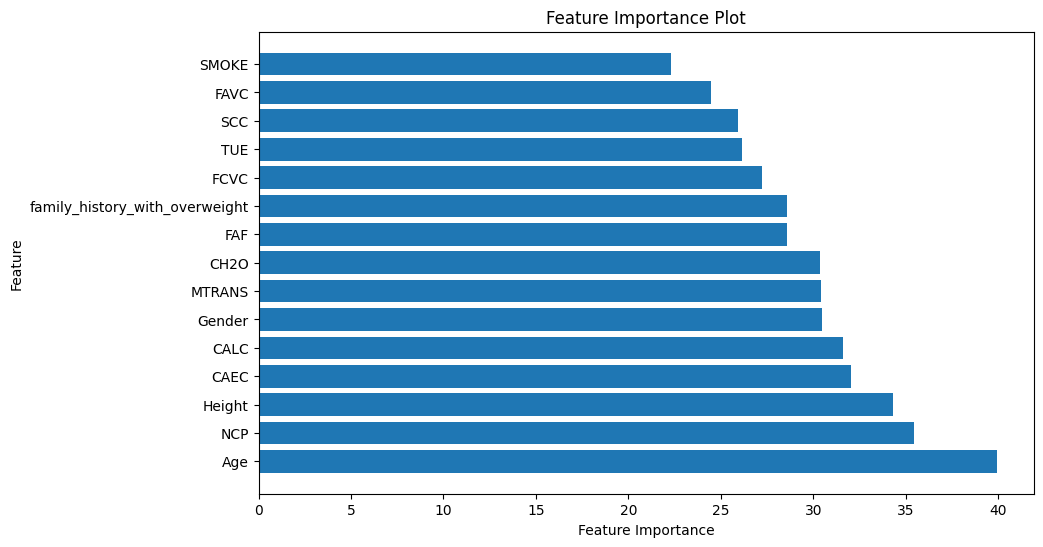

{'accuracy': 0.7943262411347518, 'f1': 0.7900636897864828, 'precision': 0.790031632377127, 'recall': 0.7943262411347518}


In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report

import numpy as np

# Hyperparameters
hidden_layer_sizes = (64, 128)
activation = 'tanh'
batch_size = 32
learning_rate = 'adaptive'
learning_rate_init = 0.01
solver = 'adam'

def datasplitter(file_path):
    data = pd.read_csv(file_path)

    # Encode non numerical columns
    label_encoder = LabelEncoder()
    encoded_columns = data.select_dtypes(include=['object']).columns
    for column in encoded_columns:
        data[column] = label_encoder.fit_transform(data[column])

    features = data.drop(columns=['NObeyesdad', 'Weight']).columns.tolist()
    X = data[features]
    y = data['NObeyesdad']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    return X_train, X_test, y_train, y_test

def plot_feature_importance(model, feature_names):
    # Retrieve the coefficients/weights of the model
    coefs = model.coefs_[0]

    # Calculate feature importance as the absolute sum of weights
    feature_importance = np.abs(coefs).sum(axis=1)

    # Sort features by importance
    sorted_indices = np.argsort(feature_importance)[::-1]
    sorted_features = [feature_names[idx] for idx in sorted_indices]
    sorted_importance = feature_importance[sorted_indices]

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(sorted_features, sorted_importance)
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importance Plot')
    plt.show()

def train_and_evaluate_model(file_path):
    X_train, X_test, y_train, y_test = datasplitter(file_path)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    model = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, max_iter=500,
                          learning_rate=learning_rate, learning_rate_init=learning_rate_init,
                          activation=activation, solver=solver, batch_size=batch_size, random_state=42)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred, average='weighted'),
        'precision': precision_score(y_test, y_pred, average='weighted'),
        'recall': recall_score(y_test, y_pred, average='weighted')
    }
    return metrics, model, X_test_scaled, y_test, y_pred

file_path = 'ObesityDataSet.csv'
X_train, X_test, y_train, y_test = datasplitter(file_path)

# Train the model
metrics, model, _, _, _ = train_and_evaluate_model(file_path)

# Plot feature importance
plot_feature_importance(model, X_train.columns.tolist())

print(metrics)


To ensure the feature importance ranking is representable, we conducted an additional test where each feature was removed individually, and the impact on model performance was observed. The results of this analysis are shown below.

These results highlight discrepancies with the initial feature importance rankings. Specifically, the two most impactful features identified are NCP and Age. While the feature importance plot suggests that Age has a higher impact than NCP, our test indicates that they are equally important. Additionally, the third most impactful feature in our experiment is FCVC, contrary to the feature importance plot which ranks it among the least important features. Height, which is ranked sixth in our experiment, is shown as the third most important feature in the feature importance plot.

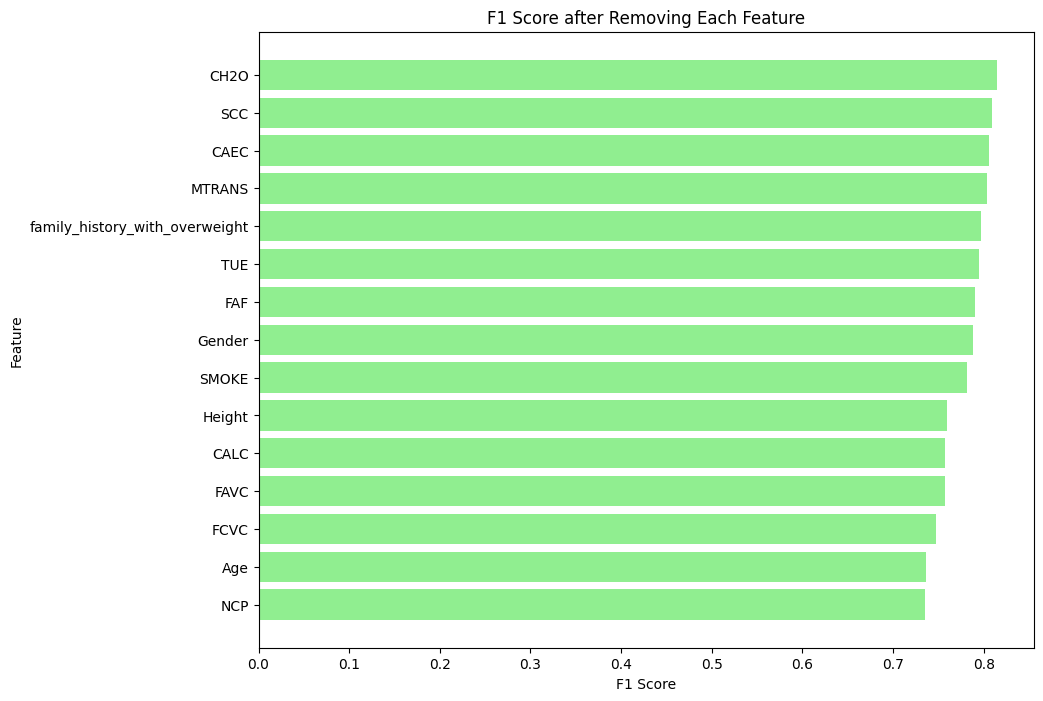

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

def evaluate_model_with_feature_removed(file_path, feature_to_remove):
    # Load the data
    X_train, X_test, y_train, y_test = datasplitter(file_path)

    # Remove the specified feature
    X_train_removed = X_train.drop(columns=feature_to_remove)
    X_test_removed = X_test.drop(columns=feature_to_remove)

    # Scale the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_removed)
    X_test_scaled = scaler.transform(X_test_removed)

    # Train the model
    model = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, max_iter=500,
                          learning_rate=learning_rate, learning_rate_init=learning_rate_init,
                          activation=activation, solver=solver, batch_size=batch_size, random_state=42)
    model.fit(X_train_scaled, y_train)

    # Evaluate the model
    y_pred = model.predict(X_test_scaled)
    f1 = f1_score(y_test, y_pred, average='weighted')

    return f1

def evaluate_model_with_features_removed(file_path, features_to_remove):
    results = {}
    for feature in features_to_remove:
        result = evaluate_model_with_feature_removed(file_path, feature)
        results[feature] = result
    return results

# File path and features
file_path = 'ObesityDataSet.csv'
X_train, X_test, y_train, y_test = datasplitter(file_path)
features_to_remove = X_train.columns.tolist()

# Evaluate the model with each feature removed
results = evaluate_model_with_features_removed(file_path, features_to_remove)

# Convert results to DataFrame
results_df = pd.DataFrame(list(results.items()), columns=['Feature', 'F1 Score'])

results_df = results_df.sort_values(by='F1 Score', ascending=False)

# Plot the results
plt.figure(figsize=(10, 8))
plt.barh(results_df['Feature'], results_df['F1 Score'], color='lightgreen')
plt.title('F1 Score after Removing Each Feature')
plt.xlabel('F1 Score')
plt.ylabel('Feature')
plt.gca().invert_yaxis()
plt.show()


#### Random Forest Feature
Also for this model we plotted the feature importance as you can see below. These are the features with the highest impact on the target variable 'Weight'.

Validation Mean Squared Error: 58.87229162136038
Validation R-squared: 0.9147501990850994
Feature Importances:
                           Feature  Importance
2                           Height    0.184182
3   family_history_with_overweight    0.142639
1                              Age    0.117934
5                             FCVC    0.084879
12                             TUE    0.070743
11                             FAF    0.070300
7                             CAEC    0.069212
6                              NCP    0.065882
9                             CH2O    0.053878
0                           Gender    0.050731
13                            CALC    0.042388
14                          MTRANS    0.019597
4                             FAVC    0.018649
10                             SCC    0.005915
8                            SMOKE    0.003071


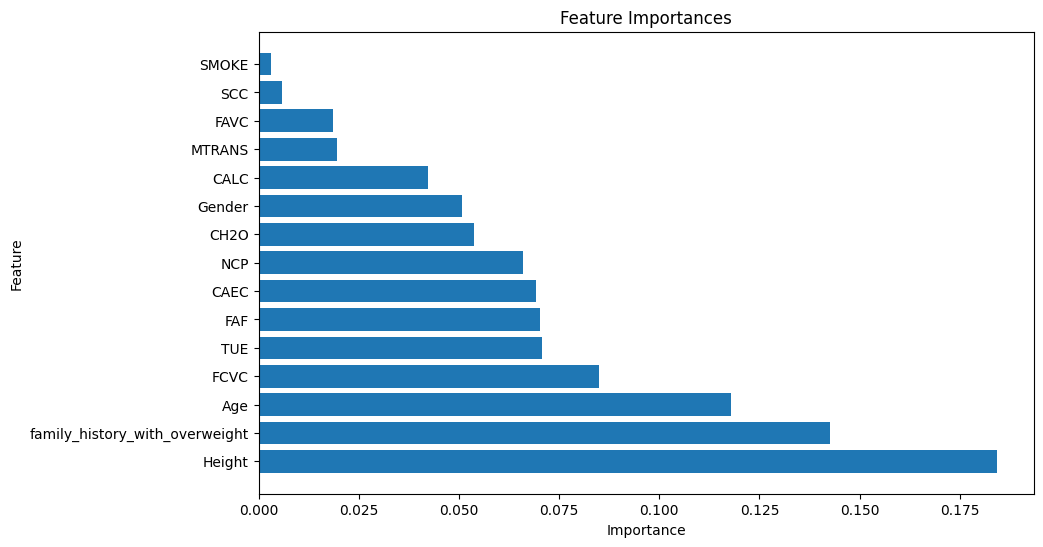

In [34]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import learning_curve
from sklearn.metrics import mean_squared_error, r2_score

def make_categorical(data):
    # Convert categorical variables to numerical variables
    data['Gender'] = pd.Categorical(data['Gender']).codes
    data['family_history_with_overweight'] = pd.Categorical(data['family_history_with_overweight']).codes
    data['FAVC'] = pd.Categorical(data['FAVC']).codes
    data['CAEC'] = pd.Categorical(data['CAEC']).codes
    data['SMOKE'] = pd.Categorical(data['SMOKE']).codes
    data['SCC'] = pd.Categorical(data['SCC']).codes
    data['CALC'] = pd.Categorical(data['CALC']).codes
    data['MTRANS'] = pd.Categorical(data['MTRANS']).codes
    data['NObeyesdad'] = pd.Categorical(data['NObeyesdad']).codes

    return data

def pre_processing_regression(path):

    data = pd.read_csv(path)

    data = make_categorical(data)

    X = data.drop('NObeyesdad', axis=1)
    X = X.drop('Weight', axis=1)

    Y = data['Weight']

    X_train, X_rest, y_train, y_rest = train_test_split(X, Y, test_size=0.2, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.5, random_state=42)

    return X_train, X_val, X_test, y_train, y_val, y_test

def evaluate_regressor(regressor, X, y):
    # Make predictions
    y_pred = regressor.predict(X)

    # Calculate Mean Squared Error
    mse = mean_squared_error(y, y_pred)  # Measures the mean-squared-error between the predicted values and the actual values

    # Calculate R-squared
    r2 = r2_score(y, y_pred)  # How well the model can explain the variance in weight => higher r2_score, better at predicting weight

    return mse, r2

def plot_learning_curves(estimator, X_train, y_train, title):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X_train, y_train, cv=5,
                                                            scoring='mean_squared_error',
                                                            train_sizes=np.linspace(0.1, 1.0, 10))
    train_scores_mean = -np.mean(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training error")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Validation error")
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Mean Squared Error")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    file = "./ObesityDataSet.csv"
    X_train, X_val, X_test, y_train, y_val, y_test = pre_processing_regression(file)
    # In pre_processing_regression, the NObeyesdad and Weight columns are removed, and the weight column is used as the target value
    # The NObeyesdad is removed because it has a high correlation with Weight

    # n_estimators: the number of decision trees in the forest
    # max_depth: the maximum depth of each tree in the forest
    # min_samples_split: the minimum number of samples required to split an internal node => can help prevent overfitting
    # min_samples_leaf: minimum number of samples required at a leaf node, can also help prevent overfitting
    # max_features: the maximum number of features considered when splitting a node
    # bootstrap: whether bootstrap samples are used when building trees; if False, the whole dataset is used to build each tree
    # random_state: sets a random seed for reproducibility
    # criterion: specifies the function to measure the quality of a split: mean squared error or mean absolute error
    # warm_start: allows previous solutions/fits to be reused

    # These parameters are the result of the grid search we conducted on the supercomputer.
    bootstrap = False
    max_depth = 30
    max_features = 'sqrt'
    min_samples_leaf = 1
    min_samples_split = 8
    n_estimators = 90
    random_state = 42

# Creating the model
    regressor = RandomForestRegressor(n_estimators=n_estimators,
                                    max_depth=max_depth,
                                    min_samples_split=min_samples_split,
                                    min_samples_leaf=min_samples_leaf,
                                    max_features=max_features,
                                    bootstrap=bootstrap,
                                    random_state=random_state)

    # Fit the model
    regressor.fit(X_train, y_train)

    # Plot learning curves
    val_mse, val_r2 = evaluate_regressor(regressor, X_val, y_val)

    print("Validation Mean Squared Error:", val_mse)
    print("Validation R-squared:", val_r2)

    feature_importances = regressor.feature_importances_

    # Pair feature importances with feature names
    feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

    # Sort features by importance
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    # Print feature importances
    print("Feature Importances:")
    print(feature_importance_df)

    # Plot feature importances
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importances')
    plt.show()

    # The graph that is shown visualizes the feature importance of the attributes on the target value 'Weight'. It is intuitive that 'Height' has a high feature importance because height is directly correlated to the weight of a person, which is an obvious relationship that the model confirms.
    # This is why we decided to highlight the 2nd most important feature, which is 'Family history with overweight', which indicates that genetics and environmental factors play a significant role in whether a person is obese/has CVD risk or not, which we did not expect to be the case.

We conducted a similar analysis as in the neural networks experiment by systematically removing each feature and observing the resulting changes.

Upon analyzing the change in the results with each feature removed, we observe that both feature importance and feature removal agree on the significance of certain features. For instance, height emerges as the most impactful feature, consistent with its high feature importance. Similarly, both methods agree on age being the third most impactful feature and smoke being the least impactful feature.

However, discrepancies arise in the alignment between feature importance and feature removal for other features. While feature importance suggests certain features as influential, their removal might not result in significant changes in performance metrics.

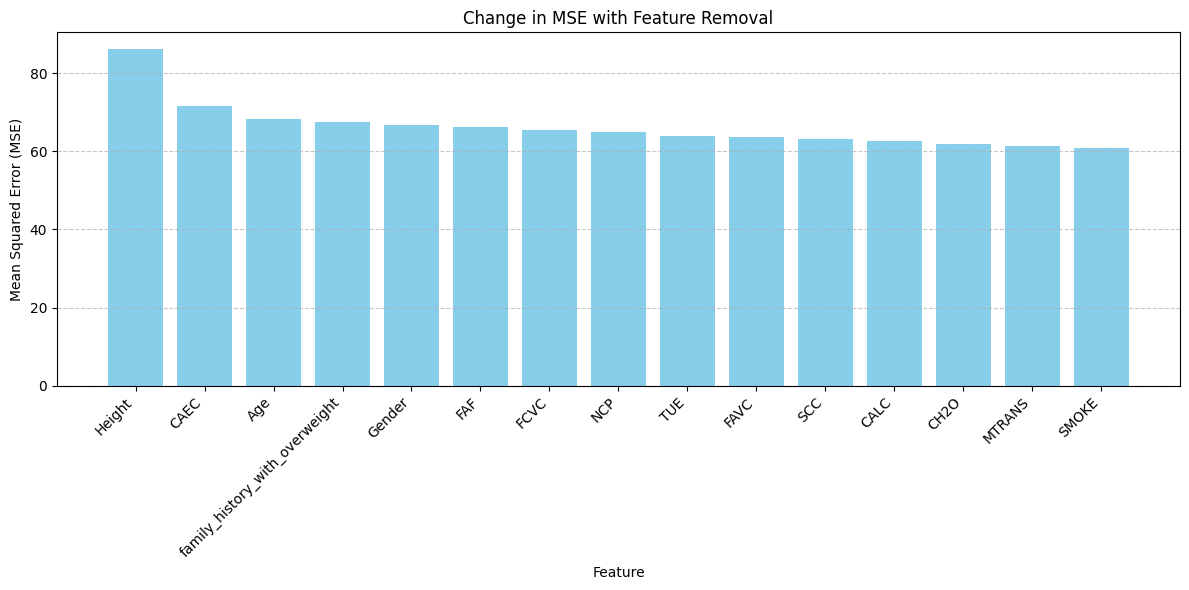

In [38]:
def evaluate_regressor_with_feature_removed(X_train, X_val, y_train, y_val, feature_to_remove):
    # Remove the specified feature
    X_train_removed = X_train.drop(columns=feature_to_remove)
    X_val_removed = X_val.drop(columns=feature_to_remove)

    # Create and train the model
    regressor = RandomForestRegressor(n_estimators=n_estimators,
                                       max_depth=max_depth,
                                       min_samples_split=min_samples_split,
                                       min_samples_leaf=min_samples_leaf,
                                       max_features=max_features,
                                       bootstrap=bootstrap,
                                       random_state=random_state)
    regressor.fit(X_train_removed, y_train)

    # Evaluate the model
    val_mse, val_r2 = evaluate_regressor(regressor, X_val_removed, y_val)

    return {'mse': val_mse, 'r2': val_r2}

def evaluate_regressor_with_features_removed(X_train, X_val, y_train, y_val, features_to_remove):
    results = {}
    for feature in features_to_remove:
        result = evaluate_regressor_with_feature_removed(X_train, X_val, y_train, y_val, feature)
        results[feature] = result
    return results

# Get the list of features
features_to_remove = X_train.columns.tolist()

# Evaluate the model with each feature removed
results = evaluate_regressor_with_features_removed(X_train, X_val, y_train, y_val, features_to_remove)

def plot_mse_change(results):
    # Sort the results by MSE values in descending order
    sorted_results = sorted(results.items(), key=lambda x: x[1]['mse'], reverse=True)
    features = [result[0] for result in sorted_results]
    mse_values = [result[1]['mse'] for result in sorted_results]

    plt.figure(figsize=(12, 6))
    plt.bar(features, mse_values, color='skyblue')
    plt.xlabel('Feature')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title('Change in MSE with Feature Removal')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Plot change in MSE for the random forest model
plot_mse_change(results)

#### Conlcusion
In summary, while feature importance provides valuable insights into the model's structure, it should be complemented with methods like feature removal analysis to gain a comprehensive understanding of feature impact.